In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\Vaibhavi\Downloads\CDC project\final_features.csv")
df["price_log"] = np.log1p(df["price"])


In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [5]:
# ============================================================
# CELL 3: LEAK-FREE TARGET ENCODING (ZIPCODE)
# ============================================================

def target_encode_zipcode(train_df, val_df, target_col="price_log", k=10):
    """
    Leak-free target encoding with smoothing.
    Encoding is learned ONLY from train_df and applied to val_df.
    """

    # Global mean from training data
    global_mean = train_df[target_col].mean()

    # Aggregate stats from TRAIN only
    agg = train_df.groupby("zipcode")[target_col].agg(["count", "sum"])

    # Compute smoothed mean
    agg["mean"] = agg["sum"] / agg["count"]
    agg["smooth"] = (
        agg["mean"] * agg["count"] + global_mean * k
    ) / (agg["count"] + k)

    # Mapping dictionary
    zipcode_mapping = agg["smooth"].to_dict()

    # Apply encoding
    train_encoded = train_df["zipcode"].map(zipcode_mapping)
    val_encoded = val_df["zipcode"].map(zipcode_mapping)

    # Handle unseen zipcodes
    train_encoded.fillna(global_mean, inplace=True)
    val_encoded.fillna(global_mean, inplace=True)

    return train_encoded.values, val_encoded.values


# Apply encoding
train_df["zipcode_enc"], val_df["zipcode_enc"] = target_encode_zipcode(
    train_df, val_df
)

print("✅ Zipcode target encoding applied (leak-free)")


✅ Zipcode target encoding applied (leak-free)


In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# ============================================================
# XGBOOST REGRESSION PIPELINE
# TABULAR vs TABULAR + IMAGE (WITH PCA + HYPERPARAM TUNING)
# LOG-PRICE TRAINING, REAL-PRICE EVALUATION
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



embedding_cols = [c for c in df.columns if c.startswith("img_")]

numeric_cols = [
    "bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront",
    "view","condition","grade","sqft_above","sqft_basement",
    "lat","long","sqft_living15","sqft_lot15"
]
numeric_cols = [c for c in numeric_cols if c in df.columns]





# ------------------------------------------------------------
# 5. PCA ON IMAGE EMBEDDINGS (TRAIN ONLY)
# ------------------------------------------------------------
PCA_DIM = 60
pca = PCA(n_components=PCA_DIM, random_state=RANDOM_STATE)

train_img = train_df[embedding_cols].fillna(0).values
val_img = val_df[embedding_cols].fillna(0).values

train_img_pca = pca.fit_transform(train_img)
val_img_pca = pca.transform(val_img)

pca_cols = [f"img_pca_{i}" for i in range(PCA_DIM)]
train_df[pca_cols] = train_img_pca
val_df[pca_cols] = val_img_pca

print(f"✅ PCA {len(embedding_cols)} → {PCA_DIM}, variance:",
      round(pca.explained_variance_ratio_.sum(), 3))

# ------------------------------------------------------------
# 6. FEATURE SETS
# ------------------------------------------------------------
tabular_features = numeric_cols + ["zipcode_enc"]
multimodal_features = tabular_features + pca_cols

def build_xy(features):
    X_train = train_df[features].fillna(0).values
    y_train = train_df["price_log"].values
    X_val = val_df[features].fillna(0).values
    y_val = val_df["price"].values
    return X_train, y_train, X_val, y_val

# ------------------------------------------------------------
# 7. BASELINE TABULAR XGBOOST (NO TUNING)
# ------------------------------------------------------------
Xtr, ytr, Xva, yva = build_xy(tabular_features)

tab_model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

tab_model.fit(Xtr, ytr)
tab_pred = np.expm1(tab_model.predict(Xva))

rmse_tab = mean_squared_error(yva, tab_pred, squared=False)
r2_tab = r2_score(yva, tab_pred)

print("\n📌 TABULAR ONLY")
print("RMSE:", rmse_tab)
print("R²  :", r2_tab)

# ------------------------------------------------------------
# 8. MULTIMODAL XGBOOST WITH HYPERPARAMETER TUNING
# ------------------------------------------------------------
Xtr, ytr, Xva, yva = build_xy(multimodal_features)

param_dist = {
    "n_estimators": [800, 1200, 1600],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_depth": [4, 5, 6, 7],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [1.0, 1.5, 2.0]
}

base_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(Xtr, ytr)

best_model = search.best_estimator_
print("\n✅ Best Multimodal Params:", search.best_params_)

mm_pred = np.expm1(best_model.predict(Xva))

rmse_mm = mean_squared_error(yva, mm_pred, squared=False)
r2_mm = r2_score(yva, mm_pred)

print("\n📌 TABULAR + IMAGE PCA (TUNED)")
print("RMSE:", rmse_mm)
print("R²  :", r2_mm)

# ------------------------------------------------------------
# 9. FINAL COMPARISON
# ------------------------------------------------------------
print("\n================ FINAL COMPARISON ================")
print(f"Tabular Only        → RMSE: {rmse_tab:.2f}, R²: {r2_tab:.4f}")
print(f"Tabular + Image PCA → RMSE: {rmse_mm:.2f}, R²: {r2_mm:.4f}")

if rmse_mm < rmse_tab:
    print("✅ Multimodal model IMPROVES performance (as expected)")
else:
    print("⚠️ No improvement — revisit embeddings / zoom / PCA_DIM")


✅ PCA 1792 → 60, variance: 0.708

📌 TABULAR ONLY
RMSE: 118597.3078195314
R²  : 0.8879155535443443
Fitting 3 folds for each of 25 candidates, totalling 75 fits

✅ Best Multimodal Params: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.0, 'n_estimators': 1600, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.6}

📌 TABULAR + IMAGE PCA (TUNED)
RMSE: 115809.26233138182
R²  : 0.8931234857920277

================ FINAL COMPARISON ================
Tabular Only        → RMSE: 118597.31, R²: 0.8879
Tabular + Image PCA → RMSE: 115809.26, R²: 0.8931
✅ Multimodal model IMPROVES performance (as expected)


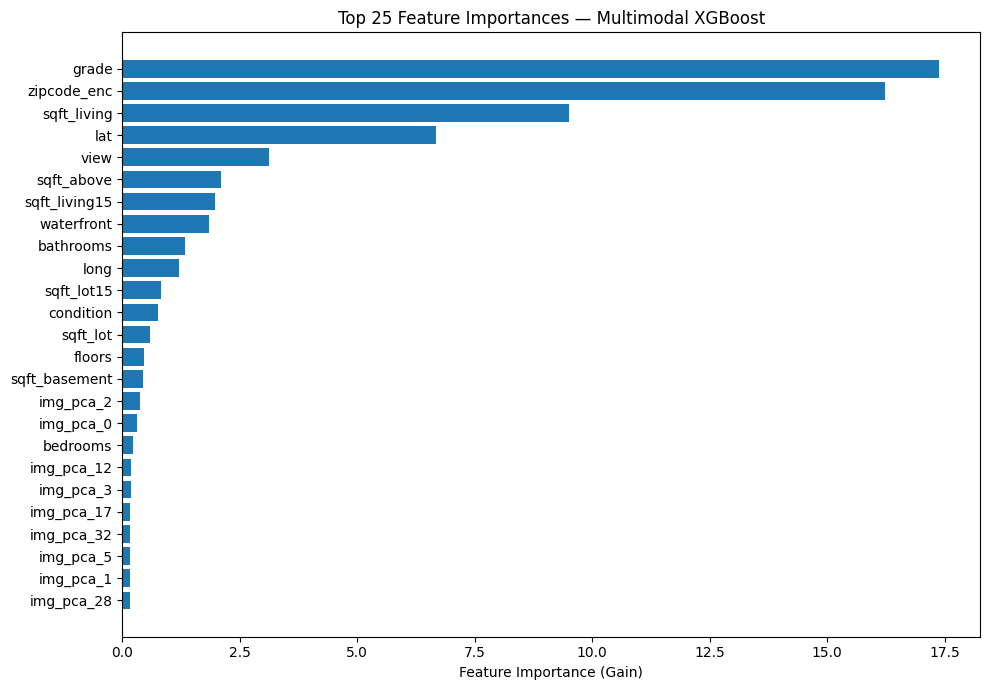

In [9]:
# ============================================================
# CELL 6: FEATURE IMPORTANCE (TOP-25) — MULTIMODAL XGBOOST
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

TOP_K = 25

# Feature names must match training order
feature_names = multimodal_features

# Extract trained booster
booster = best_model.get_booster()

# Gain-based importance (most meaningful)
importance_dict = booster.get_score(importance_type="gain")

# Build importance dataframe
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": [
        importance_dict.get(f"f{i}", 0.0)
        for i in range(len(feature_names))
    ]
})

# Keep only features that actually contributed
imp_df = imp_df[imp_df["importance"] > 0]

# Select top-K
imp_df = imp_df.sort_values("importance", ascending=False).head(TOP_K)

# Re-sort for horizontal bar plot
imp_df = imp_df.sort_values("importance", ascending=True)

# Plot
plt.figure(figsize=(10, 7))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 25 Feature Importances — Multimodal XGBoost")
plt.tight_layout()
plt.show()
